### Lokta-Volterra

In [1]:
from GDM_PCE import *

In [2]:
np.random.seed(2)

#### Load data

In [3]:
n_samples_ = [50, 150, 600]

In [4]:
Error = []
N_clusters = []
Y_real, Y_recon, Diff, L2, R2, g_all, l_all, coord_all = [], [], [], [], [], [], [], []

for i in range(len(n_samples_)):
    
    print('----Iteration: {} ----'.format(i))
    
    n_samples = n_samples_[i]

    # Probability distributions of input parameters
    pdf1 = Uniform(loc=0.9, scale=0.15)  # a
    pdf2 = Uniform(loc=0.1, scale=0.08)  # b
    #pdf2 = Uniform(loc=8, scale=10)  # c
    #pdf2 = Uniform(loc=8, scale=10)  # d
    c = 1.5
    d = 0.75

    margs = [pdf1, pdf2]
    joint = JointInd(marginals=margs)

    # Draw samples
    x = joint.rvs(n_samples)

    n = 512
    n2 = 2*n
    t = np.linspace(0, 25,  n)  # time

    out, X_f1 = [], []

    for i in range(x.shape[0]):
        out_, X_f1_ = LV(x[i, 0], x[i, 1], c, d, t)
        out_ = out_.T.flatten() # keep both species
        out.append(out_)
        X_f1.append(X_f1_)

    data = np.array(out)
    data = data.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2)))

    np.savez('data/lokta_data.npz', X=x, Y=data)

    file = np.load('data/lokta_data.npz')
    x = file['X']
    data = file['Y']
    
    start_time = time.time()

    g, coord, Grass,  residuals, index, evals = GDMaps(data=data, n_evecs=20, n_parsim=3, p=10).get()  # Perform GDMAps
    pce, error = PceModel(x=x, g=g, dist_obj=joint, max_degree=3, verbose=False).get()  # Perform PCE on the manifold
    # print('Error of PCE:', error)

    print("--- Surrogate - %s seconds ---" % (time.time() - start_time))
    
    # Adaptive clustering
    start_time = time.time()
    mat, indices, kmeans, L, n_clust, error_cl, clusters = AdaptClust(n_clust_max=65, Gr_object=Grass, data=g)
    
    print('Converged to {} clusters'.format(n_clust))
    print("--- Adaptive clustering - %s seconds ---" % (time.time() - start_time))
    
    Error.append(error_cl)
    N_clusters.append(clusters)
    g_all.append(g)
    l_all.append(L)
    coord_all.append(coord)
    
    # Interpolators
    models_all, pce_sigmas, dims = Interpolators(x=x, data=g, mat=mat, indices=indices, n_clust=n_clust, Gr=Grass, joint=joint)
    
    # Predictions    
    np.random.seed(1)
    n_pred = 5000
    x_pred = joint.rvs(n_pred)  # new samples    
    
    start_time = time.time()   

    y_real, y_f1 = [], []

    for k in range(x_pred.shape[0]):
        y_real_, y_f1_ = LV(x_pred[k, 0], x_pred[k, 1], c, d, t)
        y_real_ = y_real_.T.flatten() # keep first species
        y_real.append(y_real_)
        y_f1.append(y_f1_)

    y_real = np.array(y_real)
    y_real = y_real.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2)))
    y_real = list(y_real)

    Y_real.append(y_real)
    print("--- Comp. model cost - %s seconds ---" % (time.time() - start_time))

    start_time = time.time()   
    
    y_recon, l2, r2, diff = Prediction(x_pred=x_pred, y_real=y_real, models_all=models_all, kmeans=kmeans, mat=mat,
                                               pce=pce, pce_sigmas=pce_sigmas, Gr=Grass, dims=dims)

    Y_recon.append(y_recon)
    Diff.append(diff)
    L2.append(l2)
    R2.append(r2)
    
    print("--- Out-of-sample predictions with GDMaps PCE - %s seconds ---" % (time.time() - start_time))
    print('-------------------------------------------------------------------------------')
    print('')
    

----Iteration: 0 ----
Grassmann projection rank is:  10
--- Surrogate - 0.3473339080810547 seconds ---
A cluster of less than 5 points was detected. The algorithm stopped.
Converged to 4 clusters
--- Adaptive clustering - 1.1572749614715576 seconds ---
Validation error of PCE of sigmas:  [0.0006449 0.0007017 0.0030204 0.033299  0.0820916 0.0380489 0.0343493
 0.0889763 0.0673751 0.0649873]
--- Comp. model cost - 8.084015130996704 seconds ---
--- Out-of-sample predictions with GDMaps PCE - 433.3817536830902 seconds ---
-------------------------------------------------------------------------------

----Iteration: 1 ----
Grassmann projection rank is:  10
--- Surrogate - 0.7743911743164062 seconds ---
A cluster of less than 5 points was detected. The algorithm stopped.
Converged to 13 clusters
--- Adaptive clustering - 11.358127117156982 seconds ---
Validation error of PCE of sigmas:  [0.0007834 0.0009786 0.0042523 0.0232173 0.0604213 0.0411505 0.0473098
 0.072966  0.0715101 0.1289887]
---

In [5]:
# Save results
import os
if not os.path.exists('results'):
    os.makedirs('results')
np.savez('results/Results-Example-2.npz', x1=Error, x2=N_clusters, x3=g_all, x4=l_all, x5=coord_all, x6=Y_real, x7=Y_recon, x8=Diff, x9=L2, x10=R2)

# Load file
file_res = np.load('results/Results-Example-2.npz', allow_pickle=True)
Error = file_res['x1']
N_clusters = file_res['x2']
g_all = file_res['x3']
l_all = file_res['x4']
coord_all = file_res['x5']
Y_real = file_res['x6']
Y_recon = file_res['x7']
Diff = file_res['x8']
L2 = file_res['x9']
R2 = file_res['x10']


### Compute errors

In [6]:
# In addition to the above we'll show a Table with the mean and std of the l2 and r2 values for the 10,000 samples
# Compute the values next

# Compute mean and variance of errors
l2_mean = [np.round(np.mean(L2[i]), 4) for i in range(len(L2))]
l2_std = [np.round(np.std(L2[i]), 4) for i in range(len(L2))]

R2_mean = [np.round(np.mean(R2[i]), 4) for i in range(len(R2))]
R2_std = [np.round(np.std(R2[i]), 4) for i in range(len(R2))]

for i in range(3):
    print('Training samples: {}'.format(n_samples_[i]))
    print('L2 mean {:e} '.format(l2_mean[i]))
    print('L2 std: {:e} '. format(l2_std[i]))
    print('R2 mean: {:e} '.format(R2_mean[i]))
    print('R2 std: {:e} '.format(R2_std[i]))
    print('')

Training samples: 50
L2 mean 1.666000e-01 
L2 std: 9.720000e-02 
R2 mean: 7.907000e-01 
R2 std: 2.050000e-01 

Training samples: 150
L2 mean 8.450000e-02 
L2 std: 5.620000e-02 
R2 mean: 9.462000e-01 
R2 std: 7.270000e-02 

Training samples: 600
L2 mean 7.090000e-02 
L2 std: 4.660000e-02 
R2 mean: 9.614000e-01 
R2 std: 7.020000e-02 



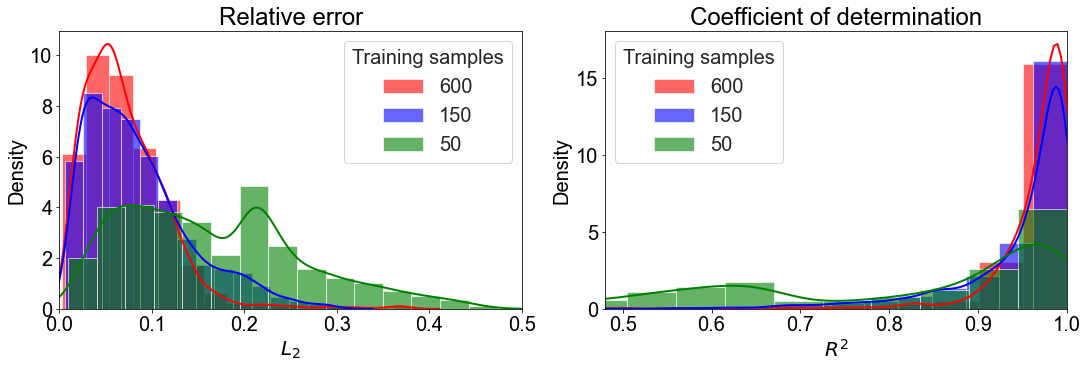

In [7]:
import os
if not os.path.exists('figures'):
    os.makedirs('figures')
    
os.makedirs('figures/Example2')

import seaborn as sns
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)
#fig.suptitle('Histogram of errors')

sns.set_style("white")
kwargs = dict(hist_kws={'alpha': .6}, kde_kws={'linewidth': 2})
colors = ['green', 'b', 'red', 'k', 'y', 'g', 'm']
# colors = ['purple', 'blue', 'orange']

for i in range(len(Y_real) - 1, -1, -1):
    sns.distplot(L2[i], ax=ax[0], label='{}'.format(n_samples_[i], l2_mean[i], l2_std[i]),
                 color=colors[i], bins=15, kde='True', **kwargs)
    sns.distplot(R2[i], ax=ax[1], label='{}'.format(n_samples_[i], R2_mean[i], R2_std[i]),
                 color=colors[i], bins=15, kde='True', **kwargs)
    sns.set_style({'axes.grid' : False})

    #ax[0].hist(L2[i], alpha=0.5, density='True', color=colors[i], bins=12,
    #label='Clusters:{}, (μ,σ)=({},{})'.format(n_clusters_[i], l2_mean[i], l2_std[i]))
    #ax[1].hist(R2[i], alpha=0.5, density='True', color=colors[i], bins=14,
    #label='Clusters:{}, (μ,σ)=({},{})'.format(n_clusters_[i], R2_mean[i], R2_std[i]))

ax[0].set_xlim(0, 0.5)
ax[0].set_title('Relative error')
ax[0].legend(fontsize=18)
ax[0].set_ylabel('Density')
ax[0].set_xlabel(r'$L_2$')
#ax[0].grid(True)
ax[1].set_xlim(0.48, 1)
ax[1].set_title('Coefficient of determination')
ax[1].legend(fontsize=18)
ax[1].set_xlabel(r'$R^2$')
#ax[1].grid('True')
ax[0].legend(title='Training samples')
ax[1].legend(title='Training samples')

plt.savefig('figures/Example2/Histograms-L2-error-R2-score.png', bbox_inches='tight', dpi=500)

### Plot error vs number of clusters

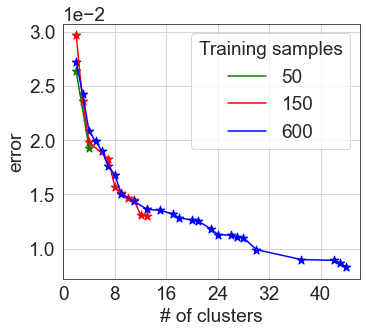

In [8]:
plt.rcParams.update({'font.size': 19})
fig, ax = plt.subplots(figsize=(7,6))
col = ['green', 'red', 'b']

for i in range(len(n_samples_)):
    plt.plot(N_clusters[i], Error[i], c=col[i], label='{}'.format(n_samples_[i]))
    plt.scatter(N_clusters[i], Error[i], c=col[i], marker='*', s=80)

plt.tight_layout(pad=4)
plt.ylabel('error')
plt.xlabel('# of clusters')
plt.legend(title='Training samples')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.locator_params(nbins=6)
plt.grid()
plt.savefig('figures/Example2/Error-vs-number-of-clusters.png', dpi=500)

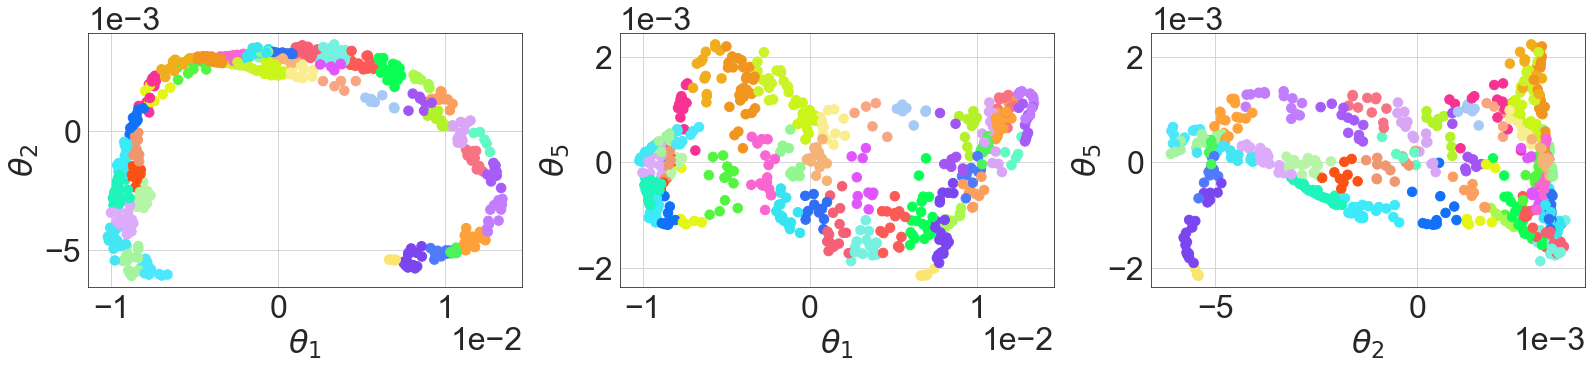

In [9]:
# Plot diffusion coordinates of the last n_samples_
plt.rcParams.update({'font.size': 32})

# Choose the last n_samples_
g = g_all[-1]
L = l_all[-1]
coord = coord_all[-1]

nlabels = np.unique(L).shape[0]
cmap = rand_cmap(nlabels=nlabels, type='bright', first_color_black=False, verbose=False)

comb1 = list(it.combinations(list(coord), 2))
comb2 = list(it.combinations([i for i in range(coord.shape[0])], 2))

# Plot first three plots
if coord.shape[0] > 2:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,5), constrained_layout=True)
    #fig.suptitle('Diffusion coordinates for {} training samples ({} clusters)'.format(n_samples_[-1], N_clusters[-1][-1]), fontsize=24)
    #j = 2
    for i in range(len(comb1)):
        ax[i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], s=90, c=L, cmap=cmap)
        ax[i].set_xlabel(r'$\theta_{}$'.format(comb1[i][0]))
        ax[i].set_ylabel(r'$\theta_{}$'.format(comb1[i][1]))
        ax[i].grid('True')
        ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        # plt.legend()
        # ax[i].set_title('Training realizations: {}'.format(trunc[i]))
        #j -= 1
    plt.savefig('figures/Example2/Diffusion-coord.png', bbox_inches='tight', dpi=500)

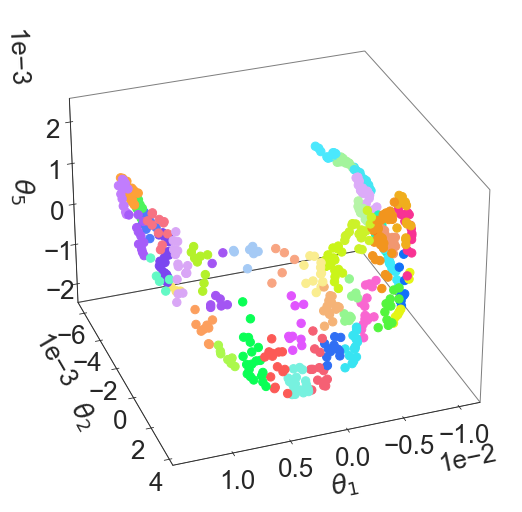

In [10]:
# 3D scatter plot of diffusion coordinates
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 26})
fig = plt.figure(figsize = (10, 7), constrained_layout=True)
ax = plt.axes(projection ="3d") 
ax.scatter3D(g[:,0], g[:,1], g[:,2], c=L, s=70, alpha=1, cmap=cmap)
ax.view_init(30, 70)
ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.set_xlabel(r'$\theta_1$', labelpad=14)
ax.set_ylabel(r'$\theta_2$', labelpad=14)
ax.set_zlabel(r'$\theta_5$', labelpad=14)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
#plt.title("simple 3D scatter plot")
plt.savefig('figures/Example2/Diffusion-coord-3d.png', bbox_inches='tight', dpi=500)

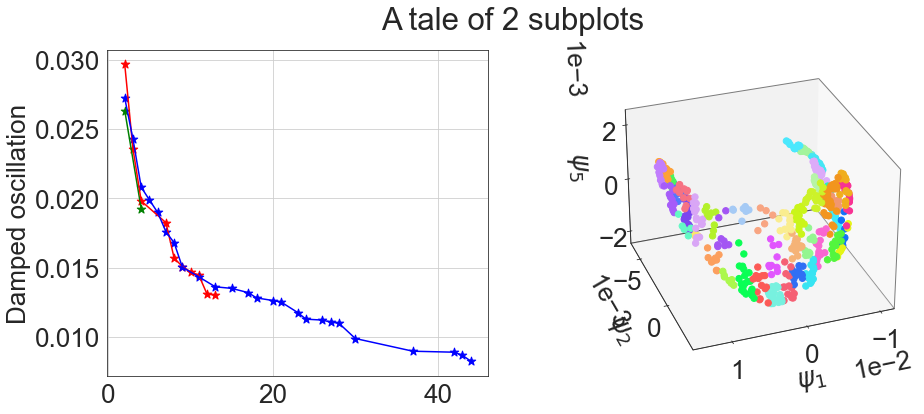

In [11]:
# Plot together
# Set up a figure twice as tall as it is wide
fig = plt.figure(figsize=(15,6))
fig.suptitle('A tale of 2 subplots')

# First subplot
ax = fig.add_subplot(1,2, 1)

t1 = np.arange(0.0, 5.0, 0.1)
t2 = np.arange(0.0, 5.0, 0.02)
t3 = np.arange(0.0, 2.0, 0.01)

for i in range(len(n_samples_)):
    ax.plot(N_clusters[i], Error[i], c=col[i], label='{}'.format(n_samples_[i]))
    ax.scatter(N_clusters[i], Error[i], c=col[i], marker='*', s=80)

ax.grid(True)
ax.set_ylabel('Damped oscillation')

# Second subplot
ax = fig.add_subplot(1,2, 2, projection='3d')

#ax = plt.axes(projection ="3d") 
ax.scatter3D(g[:,0], g[:,1], g[:,2], c=L, s=40, alpha=1, cmap=cmap)
ax.view_init(30, 70)
ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.set_xlabel(r'$\psi_1$', labelpad=14)
ax.set_ylabel(r'$\psi_2$', labelpad=14)
ax.set_zlabel(r'$\psi_5$', labelpad=14)

plt.show()

### Reference vs prediction plot

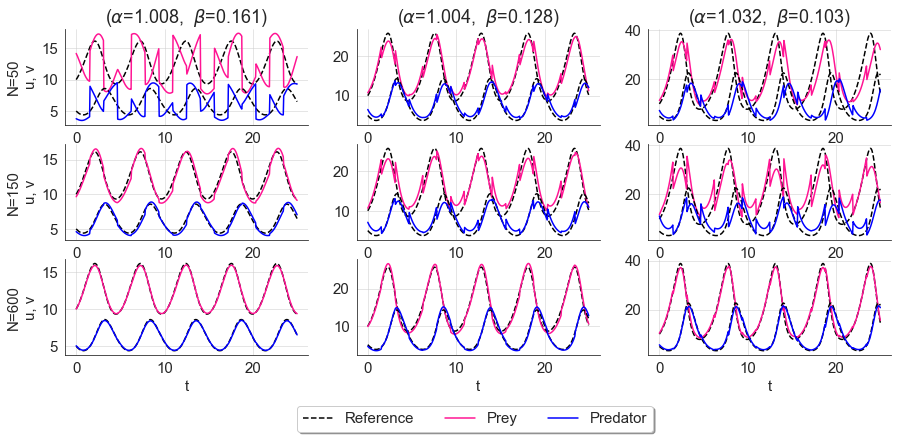

In [12]:
import random
plt.rcParams.update({'font.size': 15})
nrows, ncols = len(n_samples_), 3
  
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(17, 6), constrained_layout=True)

d = [1,62,13]
for row in range(nrows):
    for col in range(ncols):
        ax = axs[row, col]
        ax.plot(t, Y_real[row][d[col]].reshape(n2)[:n], linewidth=1.5, color='black', linestyle='dashed', label='Reference')
        ax.plot(t, Y_recon[row][d[col]].reshape(n2)[:n], linewidth=1.5, label='Prey', c='deeppink')
        ax.plot(t, Y_real[row][d[col]].reshape(n2)[n:], linewidth=1.5, color='black', linestyle='dashed')
        ax.plot(t, Y_recon[row][d[col]].reshape(n2)[n:], linewidth=1.5, label='Predator', c='blue')

        #col.title('Real vs PCE prediction')
        if row==2:
            ax.set_xlabel('t')
        if col==0:
            ax.set_ylabel('u, v')
        #ax.set_ylim(7, 16)
        if col==0:
            ax.set_ylabel('N={}\nu, v'.format(n_samples_[row]))
        if row==0:
            ax.set_title(r'($\alpha$={},  $\beta$={})'.format(round(x_pred[d[col],0],3),round(x_pred[d[col],1],3)))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        #col.legend()
        ax.grid(linewidth=0.5)
#fig.suptitle('Evolution of foxes \n Reference (dashed red) and GDMaps PCE (blue)')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, shadow='True', loc='lower center', bbox_to_anchor=(0.46, -0.07), ncol=3)
fig.subplots_adjust(right=0.8)
plt.savefig('figures/Example2/Evolution.png', bbox_inches='tight', dpi=500, transparent=True)
plt.show()